True

In [2]:
import torch
from abc import ABC, abstractmethod
import numpy as np
import pywt

"""(class Preprocessor(ABC):

    @abstractmethod
    def process(self, data):
        pass



class MyWaveletDenoiser(Preprocessor):

    def __init__(self, wavelet='db4', level=2, threshold_type='soft'):
        self.wavelet = wavelet
        self.level = level
        self.threshold_type = threshold_type

    def process(self, ecg_signal):
        # Decompose the signal using DWT
        coeffs = pywt.wavedec(ecg_signal, self.wavelet, level=self.level)

        # Determine the threshold for denoising
        sigma = np.median(np.abs(coeffs[-self.level]))
        threshold = sigma * np.sqrt(2 * np.log(len(ecg_signal)))

        # Apply soft or hard thresholding
        threshold_func = lambda x: pywt.threshold(x, threshold, mode=self.threshold_type)

        # Denoise the wavelet coefficients
        denoised_coeffs = [threshold_func(coeff) for coeff in coeffs]

        # Reconstruct the denoised signal
        denoised_signal = pywt.waverec(denoised_coeffs, self.wavelet)

        return denoised_signal
"""


"(class Preprocessor(ABC):\n\n    @abstractmethod\n    def process(self, data):\n        pass\n\n\n\nclass MyWaveletDenoiser(Preprocessor):\n\n    def __init__(self, wavelet='db4', level=2, threshold_type='soft'):\n        self.wavelet = wavelet\n        self.level = level\n        self.threshold_type = threshold_type\n\n    def process(self, ecg_signal):\n        # Decompose the signal using DWT\n        coeffs = pywt.wavedec(ecg_signal, self.wavelet, level=self.level)\n\n        # Determine the threshold for denoising\n        sigma = np.median(np.abs(coeffs[-self.level]))\n        threshold = sigma * np.sqrt(2 * np.log(len(ecg_signal)))\n\n        # Apply soft or hard thresholding\n        threshold_func = lambda x: pywt.threshold(x, threshold, mode=self.threshold_type)\n\n        # Denoise the wavelet coefficients\n        denoised_coeffs = [threshold_func(coeff) for coeff in coeffs]\n\n        # Reconstruct the denoised signal\n        denoised_signal = pywt.waverec(denoised_coeff

In [3]:

class Preprocessor(ABC):

    
    @abstractmethod
    def process(self, data):
        pass



class MyWaveletDenoiser(Preprocessor):

    def __init__(self, wavelet='db4', level=2, threshold_type='soft'):
        self.wavelet = wavelet
        self.level = level
        self.threshold_type = threshold_type

    def process(self, ecg_signal):
        # Decompose the signal using DWT
        coeffs = pywt.wavedec(ecg_signal, self.wavelet, level=self.level)

        # Determine the threshold for denoising
        sigma = np.median(np.abs(coeffs[-self.level]))
        self.threshold = sigma * np.sqrt(2 * np.log(len(ecg_signal)))
        def threshold_func(x, threshold, mode):
            magnitude = np.abs(x)
            thresholded = np.zeros_like(x)

            if mode == 'soft':
                thresholded[magnitude > threshold] = magnitude[magnitude > threshold] - threshold
                thresholded[magnitude < -threshold] = magnitude[magnitude < -threshold] + threshold
            elif mode == 'hard':
                thresholded[magnitude > threshold] = magnitude[magnitude > threshold]

            return thresholded

        # Denoise the wavelet coefficients
        denoised_coeffs = [threshold_func(coeff,self.threshold,'soft') for coeff in coeffs]

        # Reconstruct the denoised signal
        denoised_signal = pywt.waverec(denoised_coeffs, self.wavelet)

        return denoised_signal


In [ ]:
import pandas as pd
import numpy as np
import wfdb
import ast

def load_raw_data(df, sampling_rate, path):
    x=0
    if sampling_rate == 500:
        data = []
        for f in df.filename_lr:
            data.append(wfdb.rdsamp(path+f))
    else:
        data = []
        for f in df.filename_hr:
            data.append(wfdb.rdsamp(path+f))
    data = np.array([signal for signal, meta in data])
    return data

path = 'physionet.org/files/ptb-xl/1.0.3/'
sampling_rate=100
# load and convert annotation data
Y = pd.read_csv('/home/oopsie/Documents/PSIML/Projekat/physionet.org/ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
# Load raw signal data

X = load_raw_data(Y, sampling_rate, path)
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv('/home/oopsie/Documents/PSIML/Projekat/physionet.org/scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    x=0
    for key in y_dic.keys():
        x+=1
        print(x)
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10


In [11]:


X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [5]:
flattened_y_train = [item for sublist in y_train for item in sublist]
flattened_y_test = [item for sublist in y_test for item in sublist]

# Get all unique categories from flattened lists
all_categories = sorted(set(flattened_y_train + flattened_y_test))


# One-hot encode y_train
y_train_encoded = pd.DataFrame(0, index=range(len(y_train)), columns=all_categories)
for i, categories in enumerate(y_train):
    y_train_encoded.loc[i, categories] = 1

# One-hot encode y_test
y_test_encoded = pd.DataFrame(0, index=range(len(y_test)), columns=all_categories)
for i, categories in enumerate(y_test):
    y_test_encoded.loc[i, categories] = 1

# Convert to list of lists
y_train_encoded = y_train_encoded.values.tolist()
y_test_encoded = y_test_encoded.values.tolist()

In [6]:
print(list(set([tuple(yi) for yi in y_train_encoded])))
print(len(list(set([tuple(yi) for yi in y_train_encoded]))))

#print(y_train_encoded)
print(torch.tensor(y_train_encoded))

print(torch.tensor(y_test_encoded).shape)


[(1, 1, 1, 0, 0), (0, 1, 0, 0, 1), (0, 0, 1, 0, 0), (0, 0, 0, 0, 0), (1, 0, 0, 1, 0), (1, 1, 0, 0, 0), (1, 0, 0, 0, 1), (0, 1, 0, 0, 0), (0, 0, 0, 1, 1), (1, 0, 1, 0, 1), (1, 1, 1, 1, 0), (0, 1, 1, 0, 1), (0, 0, 0, 1, 0), (1, 1, 1, 0, 1), (1, 0, 0, 0, 0), (1, 0, 1, 0, 0), (0, 0, 1, 0, 1), (0, 0, 0, 0, 1), (1, 0, 0, 1, 1), (0, 1, 0, 1, 0), (0, 1, 1, 0, 0), (1, 1, 0, 0, 1)]
22
tensor([[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        ...,
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]])
torch.Size([2198, 5])


In [7]:
print(X_train.shape)
print(X_test.shape)
digital_signal_pom=X_train[:,:,0]

(19601, 5000, 12)
(2198, 5000, 12)


In [8]:
print(X_train[0,:,0])

[-0.115 -0.115 -0.115 ...  0.21   0.21   0.21 ]


In [9]:
print(X_train[0,:,0])

[-0.115 -0.115 -0.115 ...  0.21   0.21   0.21 ]


In [10]:
counter=0
for t in range(len(X_train)):
    for i in range(12):
        counter+=1
        denoiser = MyWaveletDenoiser(wavelet='db4', level=5)
        X_train[t,:,i] = denoiser.process(X_train[t,:, i])
for t in range(len(X_test)):
    for i in range(12):
        counter+=1
        denoiser = MyWaveletDenoiser(wavelet='db4', level=5)
        X_test[t,:,i] = denoiser.process(X_test[t,:, i])
print(counter)
        

261588


In [11]:
#print(counter)
#print(X)
import matplotlib.pyplot as plt

[0.0812793  0.08238529 0.08350757 ... 0.16546147 0.16520137 0.16503091]


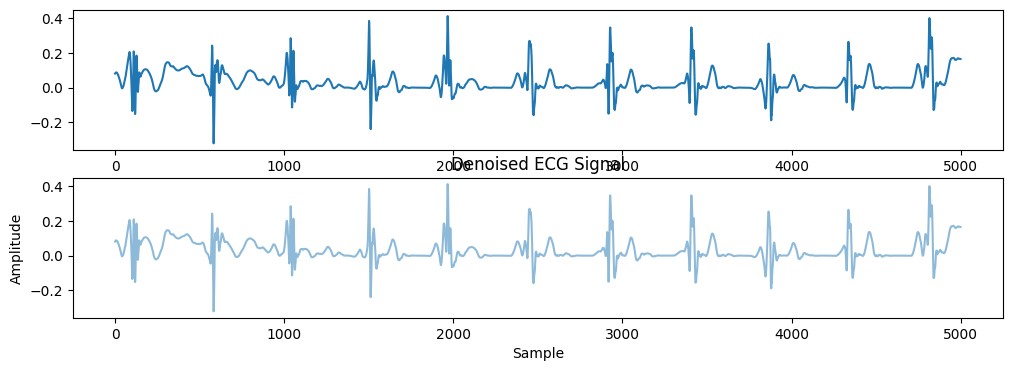

In [ ]:
class MinMaxScaler:
    def _init_(self):
        self.min = None
        self.max = None

    def fit(self, x):
        self.min = torch.min(x, dim=0, keepdim=True).values
        self.max = torch.max(x, dim=0, keepdim=True).values

    def transform(self, x):
        assert self.min is not None and self.max is not None, "Must call `fit` before `transform`"
        x_scaled = (x - self.min) / (self.max - self.min)
        return x_scaled

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

sc=MinMaxScaler()



X_train1=torch.tensor(X_train,dtype=torch.float32)
y_train1=torch.tensor(y_train_encoded,dtype=torch.float64)
sc.fit(X_train1)
X_train1=sc.transform(X_train1)
print(sc.min)
print(sc.max)
#print(y_train_encoded)

print(X_train1.shape)
print(y_train1.shape)
#print(type(X_test))
#print(type(y_test))

[0.0812793  0.08238529 0.08350757 ... 0.16546147 0.16520137 0.16503091]


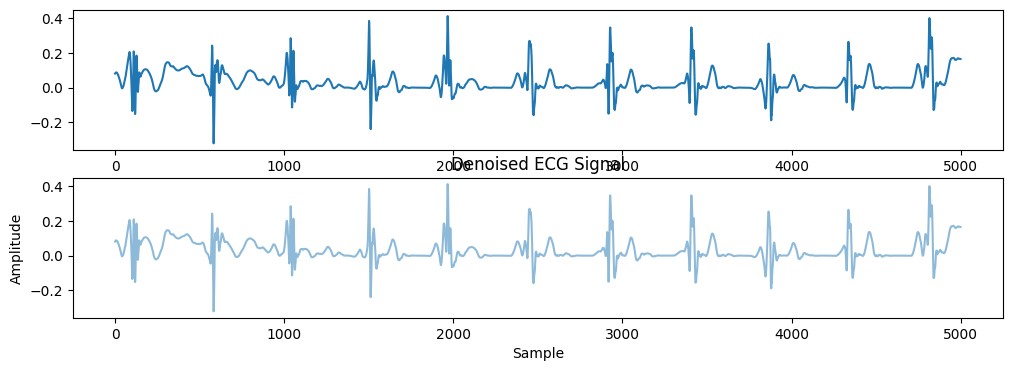

torch.Size([19601, 5000, 12])
torch.Size([19601, 5])
torch.Size([19601, 5000, 12])


In [13]:
denoiser = MyWaveletDenoiser(wavelet='db4', level=4)
print(X_train[0,:,0])
plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
plt.plot(X_train[0,:,0], alpha=1)
plt.subplot(2, 1, 2)

plt.plot(X_train[0,:, 0], alpha=0.5)
plt.title('Denoised ECG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

print(X_train1.shape)
print(y_train1.shape)
#X_input=X_train1.view(X_train1.shape[0],X_train1.shape[1],1,-1)
#X_train_reshaped=torch.tensor(X_train).view(19601,12,-1)
print(X_train1.shape)

In [15]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0,2,1)
y_train_tensor = torch.tensor(y_train1, dtype=torch.float32)

/tmp/ipykernel_5472/3409070136.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train1, dtype=torch.float32)


In [ ]:
print(type(X_test))
print(type(y_test))
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0,2,1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
print((X_test).shape)
print((y_test).shape)

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [24]:
print(X_train_tensor.shape)
print(y_train_tensor.shape)

torch.Size([19601, 12, 5000])
torch.Size([19601, 5])


In [18]:
import torch.nn as nn
class SimpleCNN(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv1d(in_channels=num_channels, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(32 * 1248, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

In [ ]:

sc=mi

In [29]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Initialize the model
num_channels = 12
num_classes = 5
model = SimpleCNN(num_channels, num_classes)
model.to('cuda')
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor[:100,:,:],y_train_tensor[:100,:])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Train the model
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    pomj=0
    for inputs, labels in train_loader:
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')
        print("1")
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        print("2")
        optimizer.step()
        print("3")
        total_loss += loss.item()
        pomj+=1
        print("Epoch: {},batch_n: {} Loss: {:.4f}".format(epoch + 1,pomj, total_loss / len(train_loader)))
torch.save(model,'model.pth')

1
2
3
Epoch: 1,batch_n: 1 Loss: 0.1243
1
2
3
Epoch: 1,batch_n: 2 Loss: 0.2245
1
2
3
Epoch: 1,batch_n: 3 Loss: 0.3149
1
2
3
Epoch: 1,batch_n: 4 Loss: 0.3559


In [25]:
 print(model.eval())

            

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv1d(12, 16, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=39936, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=5, bias=True)
    (3): Softmax(dim=1)
  )
)


In [ ]:
correct = 0
test_dataset = TensorDataset(X_train_tensor[:100,:,:],y_train_tensor[:100,:])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs.permute(0, 2, 1))
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(labels.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))